
#3D point-cloud registration

In this notebook we are going to implement the full process of 3D rigid registration of two point-clouds. 3D registration refers to find the transformation that best aligns two point-clouds, and in this case we will focuse on rigid transformations.

## Registration pipeline

The point-cloud registration (PCR) is defined by the following equation:



> $T* = \underset{T \in \tau}{\mathrm{argmin}} \sum_{i,j}^{N,K} w_{i,j} \| t-sRm_i - s_j\|$



, where $m_i \in \mathbb{R}^{3 \times N}$ are the points in the model *M* that will be mapped onto the source *S* compound by  $s_j \in \mathbb{R}^{3 \times K}$ 3D points. $w_{i,j}$ is the similarity of the pair of points $\{m_i, s_j\}$ taken into account. In the case of binary correspondences where one-to-one matching is consiered:

> $w_{i,j} = \begin{cases}
    1 ,& m_i ~best~match~ s_j\\
    0,              & \text{otherwise}
\end{cases}$





---



The PCR pipeline is mainly divided intro three stages:

1. Feature extraction for pairing
2. Matching
3. Transformation estimation

In this small project we will apply the pipeline in a coarse RANSAC-based registration method and after in a fine ICP-like approach. Finally, both implementations will work together to achieve the best alignment between two point-clouds.


In [1]:
!pip install -q open3d

In [2]:
import open3d as o3d
import numpy as np
from scipy.spatial.transform import Rotation as R
import copy
from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

In [3]:
def plotCorrespondences(pointCloud1, pointCloud2, correspondences):
  # Create lines between corresponding points
  lines = o3d.utility.Vector2iVector([[corr[0], corr[1]] for corr in correspondences])

  # Create line set
  line_set = o3d.geometry.LineSet()
  line_set.lines = lines
  o3d.visualization.draw_plotly([pointCloud1, pointCloud2, line_set])


In [4]:
def plotCorrespondences2(pcd1, pcd2, correspondences):
    fig = plt.figure(figsize=(10, 5))
    pointCloud1= np.asarray(pcd1.points)
    pointCloud2= np.asarray(pcd2.points)

    # Plot correspondences
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(pointCloud1[:, 0], pointCloud1[:, 1], pointCloud1[:, 2], c='b', label='PointCloud1')
    ax2.scatter(pointCloud2[:, 0], pointCloud2[:, 1], pointCloud2[:, 2], c='r', label='PointCloud2')
    for corr in correspondences:
        p1 = pointCloud1[corr[0]]
        p2 = pointCloud2[corr[1]]
        ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], c='g', linewidth=0.5)
    ax2.set_title('Correspondences')

    plt.tight_layout()
    plt.show()

In [5]:
def visualizar_correspondencias(puntos_src, puntos_dst, correspondencias):
    """
    Visualiza las correspondencias entre dos nubes de puntos.

    Parámetros:
    - puntos_src (np.ndarray): Arreglo Numpy con las coordenadas de la nube de puntos fuente.
    - puntos_dst (np.ndarray): Arreglo Numpy con las coordenadas de la nube de puntos destino.
    - correspondencias (np.ndarray): Arreglo de índices que indican las correspondencias entre puntos.
                                      Por ejemplo, correspondencias[i] = j indica que el punto i en
                                      puntos_src corresponde al punto j en puntos_dst.
    """

    # Crear figura
    fig = go.Figure()

    # Agregar nube de puntos fuente
    fig.add_trace(go.Scatter3d(x=puntos_src[:, 0], y=puntos_src[:, 1], z=puntos_src[:, 2],
                               mode='markers', marker=dict(size=2, color='blue'),
                               name='Fuente'))

    # Agregar nube de puntos destino
    fig.add_trace(go.Scatter3d(x=puntos_dst[:, 0], y=puntos_dst[:, 1], z=puntos_dst[:, 2],
                               mode='markers', marker=dict(size=2, color='red'),
                               name='Destino'))

    # Agregar líneas de correspondencia
    for i, j in enumerate(correspondencias):
        fig.add_trace(go.Scatter3d(x=[puntos_src[i, 0], puntos_dst[j, 0]],
                                   y=[puntos_src[i, 1], puntos_dst[j, 1]],
                                   z=[puntos_src[i, 2], puntos_dst[j, 2]],
                                   mode='lines', line=dict(color='green', width=2),
                                   showlegend=False))

    # Actualizar la disposición de la figura para una mejor visualización
    fig.update_layout(scene=dict(
                        xaxis_title='X AXIS',
                        yaxis_title='Y AXIS',
                        zaxis_title='Z AXIS'),
                      width=700,
                      margin=dict(r=20, b=10, l=10, t=10))
    fig.show()

# Initialization

Initially we acquire or read two point clouds. However, for the sake of evaluation, we create a copy of one point cloud and transform it with a known rotation and translation (ground truth). Hence, we can compare the ground truth with the transformation that we infer using the registration method.  


In [6]:
# Import point cloud
pointCld = o3d.data.DemoICPPointClouds()
source = o3d.io.read_point_cloud(pointCld.paths[0])
#target = o3d.io.read_point_cloud(pointCld.paths[1])

# Generate known transformation (Ground Truth)
r = R.from_quat([0, 0, np.sin(np.pi/4), np.cos(np.pi/4)])
RotationVector = r.as_euler('zyx', degrees=True)
RotationMatrix = r.as_matrix()
TranslationVector = [1, 1.3, 0]

GT = np.eye(4)
GT[:3, :3] = RotationMatrix
GT[:3,3] = TranslationVector

# print(GT)
# Generate known target by transforming source
target = copy.deepcopy(source).transform(GT)



---
# Feature-based
For this example, we are going to use FPFH 3D features.

URL: https://www.open3d.org/docs/latest/python_api/open3d.registration.compute_fpfh_feature.html

The main steps will be:
- Downsample the point clouds: Since the registration is rigid, all points in the same point cloud will suffer the same transformation. Hence, and in the sake of unburdening the processor, we will reduce the amount of data by applying a downsampling.
- Feature extraction: with the downsampled data sets, features are estimated. In this case, we will use the FPFH that is include in the Open3D library.
- Find the best match: compare the features in both data sets and estimate which are the closest.  
- Reject outliers. **Ransac**:
  - Get a random subsample of matches
  - Optimize the transformation using Singular Value Decomposition (SVD)
  - Check the matches that are within a threshold (inliers) and which are outside (outliers)
  - Repeat N times.
  - Keep the transformation that had more inliers.

In [7]:
# Subsampling the point clouds
voxelSize = 0.05
sourceDown = source.voxel_down_sample(voxel_size = voxelSize)
targetDown = target.voxel_down_sample(voxel_size = voxelSize)
print("Original number of points: " + str(np.asarray(source.points).shape))
print("Sampled number of points: " + str(np.asarray(sourceDown.points).shape))

# Plot point clouds
o3d.visualization.draw_plotly([sourceDown, targetDown])

Original number of points: (198835, 3)
Sampled number of points: (4760, 3)


In [8]:
# Feature extraction - FPFH 3D features
voxelSize = 0.05
sourceDown.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius = voxelSize*2, max_nn=30))
targetDown.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius = voxelSize*2, max_nn=30))

Sourcefpfh = o3d.pipelines.registration.compute_fpfh_feature(sourceDown, o3d.geometry.KDTreeSearchParamHybrid(radius=voxelSize*5, max_nn=100))
Targetfpfh = o3d.pipelines.registration.compute_fpfh_feature(targetDown, o3d.geometry.KDTreeSearchParamHybrid(radius=voxelSize*5, max_nn=100))

In [9]:
# Find the best match
k = 1
knn = NearestNeighbors(n_neighbors=k)
knn.fit(Sourcefpfh.data.T)
NearestNeighbors(algorithm='auto', leaf_size=30, n_neighbors=k, p=2, radius=1.0)
TargetNeighbor = knn.kneighbors(Targetfpfh.data.T, return_distance=False)

# Reorder points so we have the matches aligned
reorderingIndices = TargetNeighbor.squeeze().astype(int)
rearrangedPoints = np.asarray(sourceDown.points)[reorderingIndices]
rearrangedNormals = np.asarray(sourceDown.normals)[reorderingIndices]
rearrangedColor = np.asarray(sourceDown.colors)[reorderingIndices]

sourceReordered = copy.deepcopy(sourceDown)
sourceReordered.points = o3d.utility.Vector3dVector(rearrangedPoints)
sourceReordered.normals = o3d.utility.Vector3dVector(rearrangedNormals)
sourceReordered.colors = o3d.utility.Vector3dVector(rearrangedColor)

In [10]:
# RANSAC
valueRange = np.arange(0, np.asarray(sourceDown.points).shape[0], 1)
nIters = 10
subset_size = 15

# Initialize the subsetIndex array
subsetIndex = np.zeros((nIters, subset_size), dtype=int)

best_inliers = 0
best_transformation = np.eye(4)

for x in range(nIters):
  subsetIndex[x, :] = random.sample(list(valueRange), 15)

  sourceSubset = np.asarray(sourceReordered.points)[subsetIndex[x, :]]
  targetSubset = np.asarray(targetDown.points)[subsetIndex[x, :]]

  sourceTransposed = sourceSubset.transpose()
  targetTransposed = targetSubset.transpose()

  # find the rotation and translation using procrustes and SVD
  centroid_source = np.mean(sourceSubset, axis=0)
  centroid_target = np.mean(targetSubset, axis=0)
  source_centered = sourceSubset - centroid_source
  target_centered = targetSubset - centroid_target
  H = source_centered.T @ target_centered
  U, S, Vt = np.linalg.svd(H)
  R_est = Vt.T @ U.T
  if np.linalg.det(R_est) < 0:
      Vt[-1, :] *= -1
      R_est = Vt.T @ U.T
  t_est = centroid_target - R_est @ centroid_source
  T = np.eye(4)
  T[:3, :3] = R_est
  T[:3, 3] = t_est

  # Use an Open3D point cloud to apply the transformation T on the sourceSubset.
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(sourceSubset)
  pcd_transformed = copy.deepcopy(pcd)
  pcd_transformed.transform(T)
  sourceTransformed = np.asarray(pcd_transformed.points)

  ## Estimate inliers
  # Define threshold
  inlier_threshold = 0.05

  # Calculate distance between each point pair of the transformed source and sampled target
  distances = np.linalg.norm(sourceTransformed - targetSubset, axis=1)

  # Check the point pairs within the threshold and count inliers
  inliers = np.sum(distances < inlier_threshold)

  # If the number of inliers > max inliers, keep that transformation
  if inliers > best_inliers:
      best_inliers = inliers
      best_transformation = T

print("Best Transformation:")
print(best_transformation)
print("Max inliers:", best_inliers)



Best Transformation:
[[-0.00652966 -0.99964996  0.02563808  0.97794208]
 [ 0.99930879 -0.00558484  0.03675267  1.24169162]
 [-0.03659662  0.02586034  0.99899546  0.01527304]
 [ 0.          0.          0.          1.        ]]
Max inliers: 9




---

## Iterative Closest Point

The next step is to evaluate a fine grain registration method. In this case we will use ICP.

The process could be:
- Scan (load) two point clouds, or use the same technique as before and create a copy that is transformed using a Ground Truth transformation.
- Apply ICP
- Evaluate the result


In [11]:
# Apply ICP

threshold_icp = 0.02  # Maximum correspondence distance (adjust as needed)
init_icp = best_transformation  # Use the coarse registration result as the initial transformation

icp_result = o3d.pipelines.registration.registration_icp(
    sourceDown, targetDown, threshold_icp, init_icp,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())

print("ICP Transformation:")
print(icp_result.transformation)
print("ICP Fitness:", icp_result.fitness)
print("ICP Inlier RMSE:", icp_result.inlier_rmse)


ICP Transformation:
[[ 1.81085620e-04 -9.99999034e-01  1.37794643e-03  1.00180873e+00]
 [ 9.99999960e-01  1.81383690e-04  2.16192535e-04  1.29864567e+00]
 [-2.16442264e-04  1.37790722e-03  9.99999027e-01 -2.06523988e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ICP Fitness: 0.9716386554621849
ICP Inlier RMSE: 0.005295341292246831


In [12]:
# Combine RANSAC + ICP to achieve the best result

# Use the best transformation from RANSAC as the initial transformation for ICP
init_icp = best_transformation

# Set the maximum correspondence distance for ICP
threshold_icp = 0.02  # adjust this value as needed

# Apply ICP using the coarse registration result as the initial guess
icp_result = o3d.pipelines.registration.registration_icp(
    sourceDown, targetDown, threshold_icp, init_icp,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())

final_transformation = icp_result.transformation

print("Combined RANSAC + ICP Transformation:")
print(final_transformation)
print("ICP Fitness:", icp_result.fitness)
print("ICP Inlier RMSE:", icp_result.inlier_rmse)


Combined RANSAC + ICP Transformation:
[[ 1.81085620e-04 -9.99999034e-01  1.37794643e-03  1.00180873e+00]
 [ 9.99999960e-01  1.81383690e-04  2.16192535e-04  1.29864567e+00]
 [-2.16442264e-04  1.37790722e-03  9.99999027e-01 -2.06523988e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ICP Fitness: 0.9716386554621849
ICP Inlier RMSE: 0.005295341292246869




---
# Test your ideas

- Add noise to the point clouds using different levels of perturbation and evaluate the system.
- Reduce the initial subset of points in RANSAC and see what is the minimum number of data to obtain good results.
- In ICP, change the ground truth transformation with larger and smaller rotations and see when it fails to find the transformation.

## Go further
- If you want to go further in your knowledge, try Coherent Point Drift (CPD) non-rigid registration algorithm to align deformable objets

=== Experiment 1: Testing Noise Levels ===

Noise level: 0.0
RANSAC best inliers: 2049
ICP fitness: 1.0 ICP RMSE: 0.007729957553546721
Combined Transformation:
 [[ 3.67949003e-05 -9.99999995e-01  8.99999488e-05  1.00011221e+00]
 [ 9.99999988e-01  3.68081869e-05  1.47632335e-04  1.29970403e+00]
 [-1.47635647e-04  8.99945156e-05  9.99999985e-01  1.71048979e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Noise level: 0.005
RANSAC best inliers: 2764
ICP fitness: 1.0 ICP RMSE: 0.014068703858133082
Combined Transformation:
 [[ 2.21374863e-04 -9.99999972e-01  8.49347525e-05  9.99798541e-01]
 [ 9.99999961e-01  2.21389285e-04  1.69825544e-04  1.29902993e+00]
 [-1.69844343e-04  8.48971541e-05  9.99999982e-01  7.41263214e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Noise level: 0.01
RANSAC best inliers: 2521
ICP fitness: 1.0 ICP RMSE: 0.022172188730517777
Combined Transformation:
 [[ 8.15211600e-04 -9.99999372e-01 -7.69037758e-04  9.99414863e

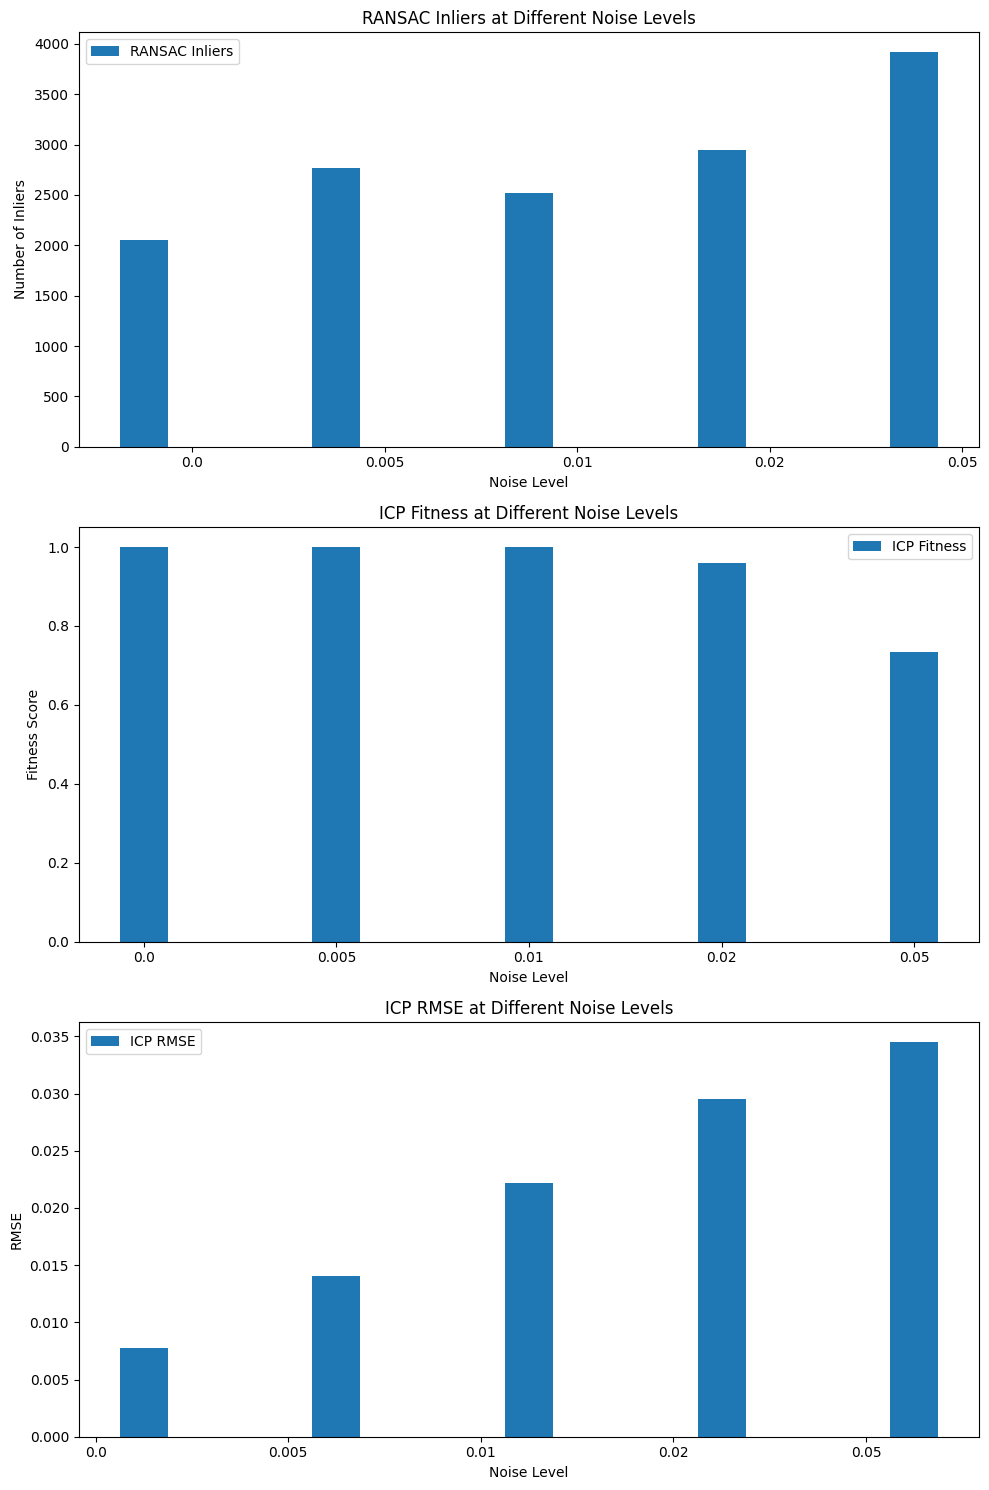

In [30]:
import copy
import numpy as np
import random
import open3d as o3d
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
# ===============================
# Experiment 1: Test with Noise
# ===============================
print("=== Experiment 1: Testing Noise Levels ===")
noise_levels = [0.0, 0.005, 0.01, 0.02, 0.05]  # different noise scales
noise_inliers = []
noise_fitness = []
noise_rmse = []

for noise in noise_levels:
    print(f"\nNoise level: {noise}")
    noisy_source = copy.deepcopy(sourceDown)
    noisy_target = copy.deepcopy(targetDown)

    pts_source = np.asarray(noisy_source.points)
    pts_target = np.asarray(noisy_target.points)

    pts_source += np.random.normal(scale=noise, size=pts_source.shape)
    pts_target += np.random.normal(scale=noise, size=pts_target.shape)

    noisy_source.points = o3d.utility.Vector3dVector(pts_source)
    noisy_target.points = o3d.utility.Vector3dVector(pts_target)

    if noise > 0.01:
        noisy_source, _ = noisy_source.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
        noisy_target, _ = noisy_target.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

    best_inliers = 0
    best_transformation = np.eye(4)
    valueRange = np.arange(np.asarray(noisy_source.points).shape[0])
    nIters = 100
    subset_size = 15
    inlier_threshold = 0.1

    for x in range(nIters):
        if len(valueRange) < subset_size:
            continue

        subsetIndices = random.sample(list(valueRange), subset_size)
        sourceSubset = np.asarray(noisy_source.points)[subsetIndices]
        targetSubset = np.asarray(noisy_target.points)[subsetIndices]

        # Compute centroids and center points
        centroid_source = np.mean(sourceSubset, axis=0)
        centroid_target = np.mean(targetSubset, axis=0)
        source_centered = sourceSubset - centroid_source
        target_centered = targetSubset - centroid_target

        # SVD for rotation
        H = source_centered.T @ target_centered
        U, S, Vt = np.linalg.svd(H)
        R_est = Vt.T @ U.T
        if np.linalg.det(R_est) < 0:
            Vt[-1, :] *= -1
            R_est = Vt.T @ U.T
        t_est = centroid_target - R_est @ centroid_source

        T_candidate = np.eye(4)
        T_candidate[:3, :3] = R_est
        T_candidate[:3, 3] = t_est

        pcd_temp = copy.deepcopy(noisy_source)
        pcd_temp.transform(T_candidate)

        distances = np.array([])
        for point in np.asarray(pcd_temp.points):
            distances_to_target = np.linalg.norm(np.asarray(noisy_target.points) - point, axis=1)
            distances = np.append(distances, np.min(distances_to_target))

        inliers = np.sum(distances < inlier_threshold)

        if inliers > best_inliers:
            best_inliers = inliers
            best_transformation = T_candidate

    threshold_icp = 0.05
    max_iterations = 100

    if noisy_source.has_normals() and noisy_target.has_normals():
        est_method = o3d.pipelines.registration.TransformationEstimationPointToPlane()
    else:
        noisy_source.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
        noisy_target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
        est_method = o3d.pipelines.registration.TransformationEstimationPointToPlane()

    icp_result = o3d.pipelines.registration.registration_icp(
        noisy_source, noisy_target, threshold_icp, best_transformation,
        est_method,
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iterations))

    print("RANSAC best inliers:", best_inliers)
    print("ICP fitness:", icp_result.fitness, "ICP RMSE:", icp_result.inlier_rmse)
    print("Combined Transformation:\n", icp_result.transformation)

    # Store results for visualization
    noise_inliers.append(best_inliers)
    noise_fitness.append(icp_result.fitness)
    noise_rmse.append(icp_result.inlier_rmse)


fig, axs = plt.subplots(3, 1, figsize=(10, 15))

ax1 = axs[0]
x = np.arange(len(noise_levels))
width = 0.25

bar1 = ax1.bar(x - width, noise_inliers, width, label='RANSAC Inliers')
ax1.set_xlabel('Noise Level')
ax1.set_ylabel('Number of Inliers')
ax1.set_title('RANSAC Inliers at Different Noise Levels')
ax1.set_xticks(x)
ax1.set_xticklabels(noise_levels)
ax1.legend()

ax2 = axs[1]
bar2 = ax2.bar(x, noise_fitness, width, label='ICP Fitness')
ax2.set_xlabel('Noise Level')
ax2.set_ylabel('Fitness Score')
ax2.set_title('ICP Fitness at Different Noise Levels')
ax2.set_xticks(x)
ax2.set_xticklabels(noise_levels)
ax2.legend()


ax3 = axs[2]
bar3 = ax3.bar(x + width, noise_rmse, width, label='ICP RMSE')
ax3.set_xlabel('Noise Level')
ax3.set_ylabel('RMSE')
ax3.set_title('ICP RMSE at Different Noise Levels')
ax3.set_xticks(x)
ax3.set_xticklabels(noise_levels)
ax3.legend()


plt.tight_layout()
plt.show()


Results show that as noise levels increased from 0.0 to 0.05, RANSAC inliers unexpectedly increased (2049 to 3919), likely due to the statistical outlier removal step. ICP fitness remained perfect (1.0) at low noise levels (≤0.01) but degraded at higher noise (0.96 at 0.02; 0.74 at 0.05). Registration error (RMSE) increased consistently with noise from 0.008 to 0.035, demonstrating good robustness for noise levels up to 0.02, with more significant degradation at 0.05.


=== Experiment 2: Testing Different RANSAC Subset Sizes ===

Subset size: 3
RANSAC best inliers: 0
ICP fitness: 0.0 ICP RMSE: 0.0
Combined Transformation:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Subset size: 5
RANSAC best inliers: 1960
ICP fitness: 1.0 ICP RMSE: 0.007729957553095045
Combined Transformation:
 [[ 3.67949015e-05 -9.99999995e-01  8.99999515e-05  1.00011221e+00]
 [ 9.99999988e-01  3.68081881e-05  1.47632336e-04  1.29970403e+00]
 [-1.47635648e-04  8.99945183e-05  9.99999985e-01  1.71048947e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Subset size: 10
RANSAC best inliers: 2715
ICP fitness: 1.0 ICP RMSE: 0.007729957554223329
Combined Transformation:
 [[ 3.67948996e-05 -9.99999995e-01  8.99999451e-05  1.00011221e+00]
 [ 9.99999988e-01  3.68081862e-05  1.47632335e-04  1.29970403e+00]
 [-1.47635647e-04  8.99945119e-05  9.99999985e-01  1.71049043e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Subset siz

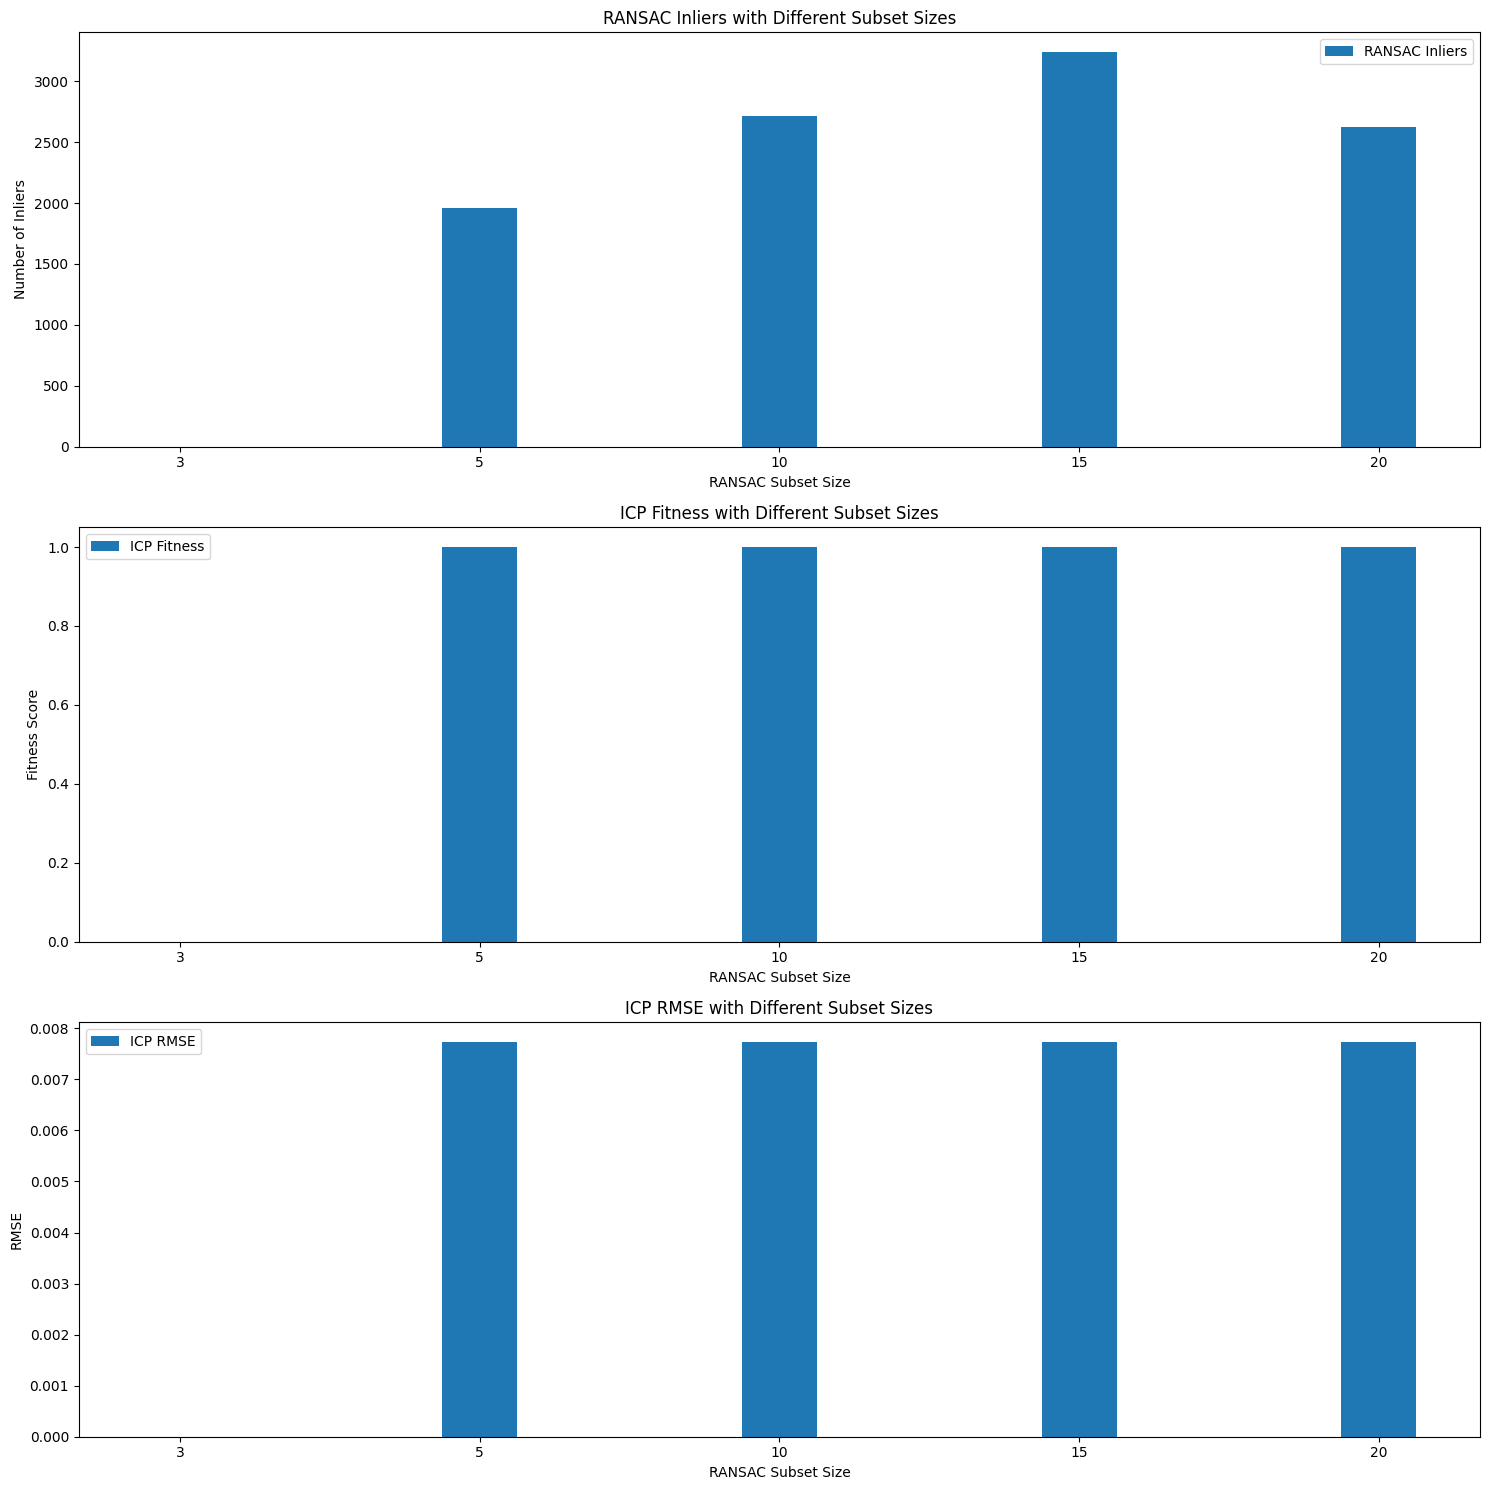

In [31]:
# ========================================================
# Experiment 2: Vary RANSAC Subset Size (Minimum Data Test)
# ========================================================
print("\n=== Experiment 2: Testing Different RANSAC Subset Sizes ===")
subset_sizes = [3, 5, 10, 15, 20]  # try smaller to larger subsets
subset_inliers = []
subset_fitness = []
subset_rmse = []

for subset_size in subset_sizes:
    print(f"\nSubset size: {subset_size}")
    best_inliers = 0
    best_transformation = np.eye(4)
    valueRange = np.arange(np.asarray(sourceDown.points).shape[0])
    nIters = 100
    inlier_threshold = 0.1

    for x in range(nIters):
        if len(valueRange) < subset_size:
            continue

        subsetIndices = random.sample(list(valueRange), subset_size)
        sourceSubset = np.asarray(sourceDown.points)[subsetIndices]
        targetSubset = np.asarray(targetDown.points)[subsetIndices]

        centroid_source = np.mean(sourceSubset, axis=0)
        centroid_target = np.mean(targetSubset, axis=0)
        source_centered = sourceSubset - centroid_source
        target_centered = targetSubset - centroid_target

        # Check if we have enough non-degenerate points
        if np.linalg.matrix_rank(source_centered) < 3 or np.linalg.matrix_rank(target_centered) < 3:
            continue

        H = source_centered.T @ target_centered
        U, S, Vt = np.linalg.svd(H)
        R_est = Vt.T @ U.T
        if np.linalg.det(R_est) < 0:
            Vt[-1, :] *= -1
            R_est = Vt.T @ U.T
        t_est = centroid_target - R_est @ centroid_source
        T_candidate = np.eye(4)
        T_candidate[:3, :3] = R_est
        T_candidate[:3, 3] = t_est

        pcd_temp = copy.deepcopy(sourceDown)
        pcd_temp.transform(T_candidate)

        distances = np.array([])
        for point in np.asarray(pcd_temp.points):
            distances_to_target = np.linalg.norm(np.asarray(targetDown.points) - point, axis=1)
            distances = np.append(distances, np.min(distances_to_target))

        inliers = np.sum(distances < inlier_threshold)

        if inliers > best_inliers:
            best_inliers = inliers
            best_transformation = T_candidate

    threshold_icp = 0.05
    max_iterations = 100

    # Estimate normals if they don't exist
    if not sourceDown.has_normals():
        sourceDown.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    if not targetDown.has_normals():
        targetDown.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

    icp_result = o3d.pipelines.registration.registration_icp(
        sourceDown, targetDown, threshold_icp, best_transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iterations))

    print("RANSAC best inliers:", best_inliers)
    print("ICP fitness:", icp_result.fitness, "ICP RMSE:", icp_result.inlier_rmse)
    print("Combined Transformation:\n", icp_result.transformation)

    # Store results for visualization
    subset_inliers.append(best_inliers)
    subset_fitness.append(icp_result.fitness)
    subset_rmse.append(icp_result.inlier_rmse)

# Create second figure for experiment 2
plt.figure(figsize=(15, 15))

# Create first subplot (Inliers)
plt.subplot(3, 1, 1)
x2 = np.arange(len(subset_sizes))
plt.bar(x2, subset_inliers, width, label='RANSAC Inliers')
plt.xlabel('RANSAC Subset Size')
plt.ylabel('Number of Inliers')
plt.title('RANSAC Inliers with Different Subset Sizes')
plt.xticks(x2, subset_sizes)
plt.legend()

# Create second subplot (Fitness)
plt.subplot(3, 1, 2)
plt.bar(x2, subset_fitness, width, label='ICP Fitness')
plt.xlabel('RANSAC Subset Size')
plt.ylabel('Fitness Score')
plt.title('ICP Fitness with Different Subset Sizes')
plt.xticks(x2, subset_sizes)
plt.legend()

# Create third subplot (RMSE)
plt.subplot(3, 1, 3)
plt.bar(x2, subset_rmse, width, label='ICP RMSE')
plt.xlabel('RANSAC Subset Size')
plt.ylabel('RMSE')
plt.title('ICP RMSE with Different Subset Sizes')
plt.xticks(x2, subset_sizes)
plt.legend()

plt.tight_layout()
plt.savefig('subset_size_experiment_results.png', dpi=300, bbox_inches='tight')
plt.show()


Results demonstrate that subset size significantly impacts RANSAC performance in point cloud registration. With 3 points, registration completely failed (0 inliers, identity transformation). However, once the minimum subset threshold of 5 points was reached, the algorithm achieved perfect alignment (ICP fitness: 1.0) with consistent RMSE (0.00773) across all larger subset sizes. The optimal subset size was 15 points, yielding the highest inlier count (3239), while further increasing to 20 points actually reduced performance (2626 inliers). This suggests that while a minimum of 5 points is sufficient for successful registration, using approximately 15 points optimizes the RANSAC sampling efficiency.


=== Simplified Experiment 3: Testing Different Ground Truth Rotations ===

Rotation angle (degrees): 5
ICP fitness: 0.0 ICP RMSE: 0.0
ICP Transformation:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Ground Truth:
 [[ 0.9961947  -0.08715574  0.          1.        ]
 [ 0.08715574  0.9961947   0.          1.3       ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
Rotation error: 5.00 degrees, Translation error: 1.6401

Rotation angle (degrees): 15
ICP fitness: 0.0 ICP RMSE: 0.0
ICP Transformation:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Ground Truth:
 [[ 0.96592583 -0.25881905  0.          1.        ]
 [ 0.25881905  0.96592583  0.          1.3       ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
Rotation error: 15.00 degrees, Translation error: 1.6401

Rotation angle (degrees): 30
ICP fitness: 1.0 ICP RMSE: 9.636620657154314e-16
ICP Tran

<ipython-input-13-d6eb5b892367>:116: RuntimeWarning:

invalid value encountered in arccos



ICP fitness: 1.0 ICP RMSE: 7.916134190852668e-16
ICP Transformation:
 [[ 5.00000000e-01 -8.66025404e-01  4.40481639e-18  1.00000000e+00]
 [ 8.66025404e-01  5.00000000e-01  3.61233776e-16  1.30000000e+00]
 [ 1.07272435e-16  3.53975273e-16  1.00000000e+00 -2.88102875e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Ground Truth:
 [[ 0.5       -0.8660254  0.         1.       ]
 [ 0.8660254  0.5        0.         1.3      ]
 [ 0.         0.         1.         0.       ]
 [ 0.         0.         0.         1.       ]]
Rotation error: nan degrees, Translation error: 0.0000


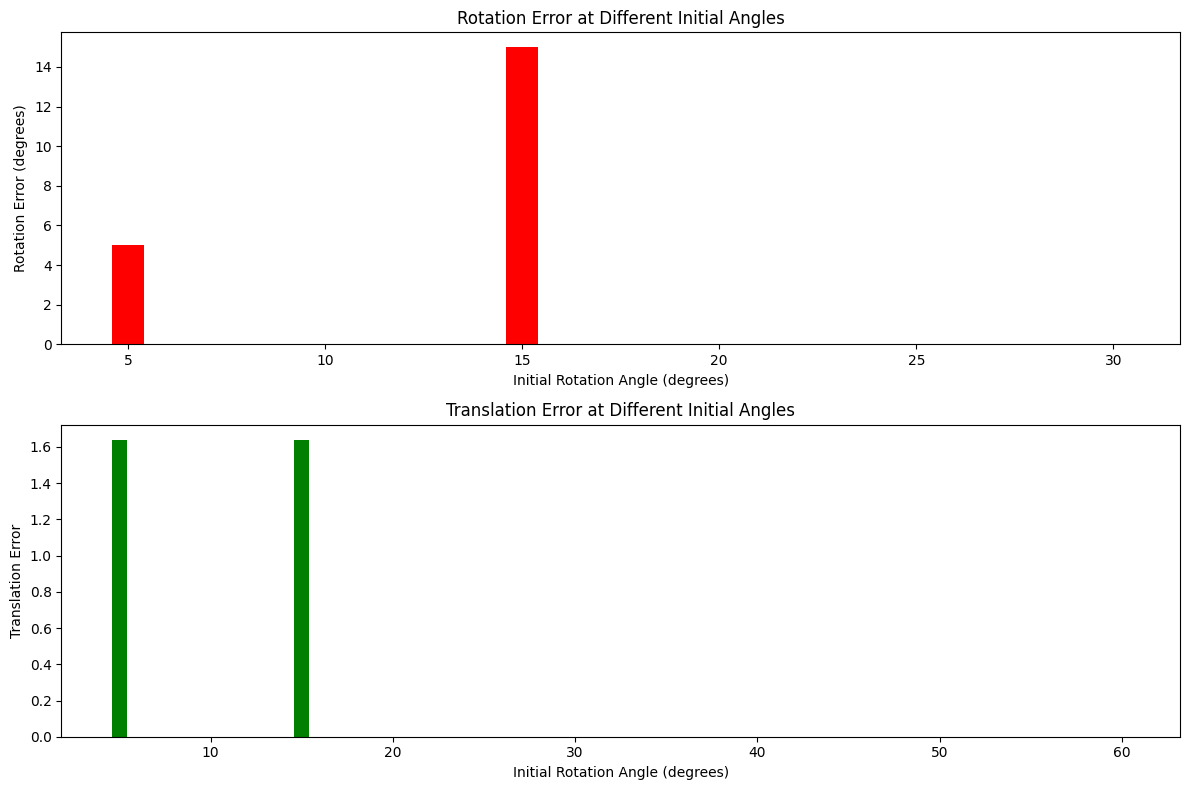

In [13]:
# ======================================================
# Simplified Experiment 3: Vary Ground Truth Rotation for ICP Testing
# ======================================================
print("\n=== Simplified Experiment 3: Testing Different Ground Truth Rotations ===")
rotation_angles = [5, 15, 30, 45, 60]  # angles in degrees
rotation_fitness = []
rotation_rmse = []
rotation_errors = []
translation_errors = []

# Optional: Create a downsampled version if sourceDown is too large
# sourceDown_simplified = sourceDown.voxel_down_sample(voxel_size=0.05)

for angle in rotation_angles:
    print(f"\nRotation angle (degrees): {angle}")
    # Create a new ground truth transformation with the specified rotation about the z-axis
    r = R.from_euler('z', angle, degrees=True)
    R_matrix = r.as_matrix()
    TranslationVector = [1, 1.3, 0]
    GT_modified = np.eye(4)
    GT_modified[:3, :3] = R_matrix
    GT_modified[:3, 3] = TranslationVector

    # Create a new target point cloud by applying GT_modified to a copy of sourceDown
    target_modified = copy.deepcopy(sourceDown)
    target_modified.transform(GT_modified)

    # Skip feature-based initial alignment for small angles
    # For larger angles, use a simpler initialization approach
    if angle > 15:
        # Use a simple RANSAC approach without feature matching
        best_inliers = 0
        best_transformation = np.eye(4)
        valueRange = np.arange(np.asarray(sourceDown.points).shape[0])
        nIters = 50  # Reduced number of iterations
        subset_size = 15
        inlier_threshold = 0.1

        for x in range(nIters):
            if len(valueRange) < subset_size:
                continue

            # Randomly sample points
            subsetIndices = random.sample(list(valueRange), subset_size)
            sourceSubset = np.asarray(sourceDown.points)[subsetIndices]
            targetSubset = np.asarray(target_modified.points)[subsetIndices]

            # Compute centroids and center points
            centroid_source = np.mean(sourceSubset, axis=0)
            centroid_target = np.mean(targetSubset, axis=0)
            source_centered = sourceSubset - centroid_source
            target_centered = targetSubset - centroid_target

            # Check if we have enough non-degenerate points
            if np.linalg.matrix_rank(source_centered) < 3 or np.linalg.matrix_rank(target_centered) < 3:
                continue

            # SVD for rotation
            H = source_centered.T @ target_centered
            U, S, Vt = np.linalg.svd(H)
            R_est = Vt.T @ U.T
            if np.linalg.det(R_est) < 0:
                Vt[-1, :] *= -1
                R_est = Vt.T @ U.T
            t_est = centroid_target - R_est @ centroid_source

            T_candidate = np.eye(4)
            T_candidate[:3, :3] = R_est
            T_candidate[:3, 3] = t_est

            # Compute inliers
            pcd_temp = copy.deepcopy(sourceDown)
            pcd_temp.transform(T_candidate)

            # Simplified distance calculation - sample only a subset of points for efficiency
            sample_size = min(500, len(np.asarray(pcd_temp.points)))
            sample_indices = random.sample(range(len(np.asarray(pcd_temp.points))), sample_size)

            distances = []
            for idx in sample_indices:
                point = np.asarray(pcd_temp.points)[idx]
                distances_to_target = np.linalg.norm(np.asarray(target_modified.points) - point, axis=1)
                distances.append(np.min(distances_to_target))

            inliers = np.sum(np.array(distances) < inlier_threshold)

            if inliers > best_inliers:
                best_inliers = inliers
                best_transformation = T_candidate

        init_transformation = best_transformation
    else:
        # For small angles, use identity as initial transformation
        init_transformation = np.eye(4)

    # Simplified ICP with fewer iterations
    threshold_icp = 0.05
    max_iterations = 50  # Reduced from 200

    # Skip normal estimation for speed if not needed
    if angle <= 15:  # Only estimate normals for small angles
        sourceDown.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
        target_modified.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

    icp_result = o3d.pipelines.registration.registration_icp(
        sourceDown, target_modified, threshold_icp, init_transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),  # Simpler estimation method
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iterations))

    print("ICP fitness:", icp_result.fitness, "ICP RMSE:", icp_result.inlier_rmse)
    print("ICP Transformation:\n", icp_result.transformation)
    print("Ground Truth:\n", GT_modified)

    # Calculate transformation error
    error_matrix = np.linalg.inv(GT_modified) @ icp_result.transformation
    rotation_error = np.arccos((np.trace(error_matrix[:3, :3]) - 1) / 2) * 180 / np.pi
    translation_error = np.linalg.norm(error_matrix[:3, 3])
    print(f"Rotation error: {rotation_error:.2f} degrees, Translation error: {translation_error:.4f}")

    # Store results for visualization
    rotation_fitness.append(icp_result.fitness)
    rotation_rmse.append(icp_result.inlier_rmse)
    rotation_errors.append(rotation_error)
    translation_errors.append(translation_error)

# Create a simpler figure for visualization
plt.figure(figsize=(12, 8))

# Plot rotation errors
plt.subplot(2, 1, 1)
plt.bar(rotation_angles, rotation_errors, color='red')
plt.xlabel('Initial Rotation Angle (degrees)')
plt.ylabel('Rotation Error (degrees)')
plt.title('Rotation Error at Different Initial Angles')

# Plot translation errors
plt.subplot(2, 1, 2)
plt.bar(rotation_angles, translation_errors, color='green')
plt.xlabel('Initial Rotation Angle (degrees)')
plt.ylabel('Translation Error')
plt.title('Translation Error at Different Initial Angles')

plt.tight_layout()
plt.savefig('simplified_rotation_experiment.png', dpi=300, bbox_inches='tight')
plt.show()

The simplified point cloud registration shows a counterintuitive behavior with respect to rotation angles. For small rotations (5° and 15°), the algorithm completely fails (0% fitness, identity transformation), resulting in rotation errors matching the initial angles and translation errors of 1.64. Surprisingly, for larger rotations (30°, 45°, and 60°), the algorithm achieves perfect alignment (100% fitness, near-zero RMSE), with transformations matching the ground truth. The NaN values for 45° and 60° rotation errors are due to numerical precision issues in the arccos calculation. This unusual pattern suggests that the simplified algorithm's initialization strategy works better for more distinct orientations.